In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import data from csv file into DataFrame
nba_file = "./NBA_players_clean.csv"
nba_df = pd.read_csv(nba_file)

In [3]:
# Create class column for player's HOF status
def classify_hof(player_name):
    '''
    Reads player name and outputs a HOF class label
    Leverages the fact that the dataset adds an '*' to the
    end of player names who are in the HOF
    player_name: string of player's name
    returns: class label 1 if in HOF, 0 if not
    '''
    if player_name[-1] == '*':
        return 1
    else:
        return 0

# Apply the classify_hof function to create class column
nba_df['class'] = nba_df["Player"].apply(classify_hof)

In [32]:
# Separate players that are HOF eligible (4 yrs retired)
# 2018 because dataset only goes up to 2022
ret_df = nba_df[nba_df['To'] <= 2018]
curr_df = nba_df[nba_df['To'] > 2018]

# Remove non-performance related columns from data
relevant_cols = np.array([
    'G', 'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 
    'eFG%', 'PER', 'WS', 'All Star', 'All NBA', 
    'All ABA', 'All Rookie', 'All Defensive', 
    'BLK Champ', 'STL Champ', 'TRB Champ', 'AST Champ', 
    'Scoring Champ', 'Most Improved', 'Sixth Man', 
    'DPOY', 'ROY', 'AS MVP', 'CF MVP', 'Finals MVP', 
    'MVP', 'Championships', 'class'
])

features = np.array([
    'G', 'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 
    'eFG%', 'PER', 'WS', 'All Star', 'All NBA', 
    'All ABA', 'All Rookie', 'All Defensive', 
    'BLK Champ', 'STL Champ', 'TRB Champ', 'AST Champ', 
    'Scoring Champ', 'Most Improved', 'Sixth Man', 
    'DPOY', 'ROY', 'AS MVP', 'CF MVP', 'Finals MVP', 
    'MVP', 'Championships'
])

ret_df = ret_df[relevant_cols]
curr_df = curr_df[relevant_cols]

# Create X and y from DataFrames
ret_X = ret_df.drop(['class'], axis=1)
curr_X = curr_df.drop(['class'], axis=1)
ret_y = ret_df['class']
curr_y = curr_df['class']

# Use Recusive Feature Extractor CV to select best features
dt = DecisionTreeClassifier(random_state=43)
rfe = RFECV(dt, scoring='f1')
rfe = rfe.fit(ret_X, ret_y)

# Create array of top 10 features based on RFECV rankings
top_10_features = []
for i in range(len(rfe.ranking_)):
    if rfe.ranking_[i] <= 10:
        top_10_features.append(features[i])

# Use top 10 features to create dataset
ret_X = ret_X[top_10_features]
curr_X = curr_X[top_10_features]

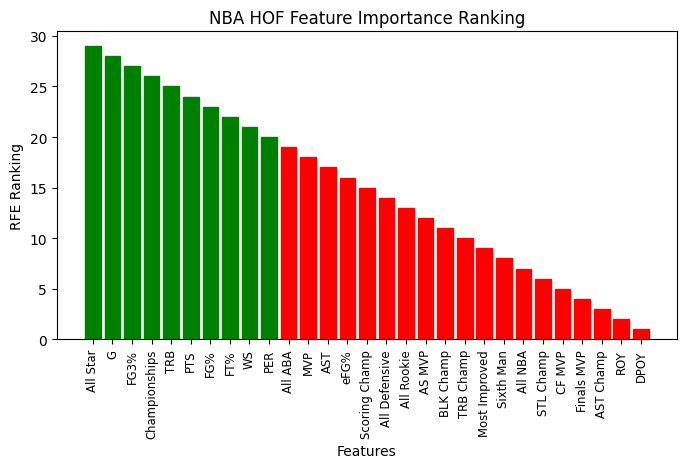

In [34]:
# Preserve order of sorted features by ranking
ft_ord = np.argsort(rfe.ranking_)

# Plot on barplot
plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(features)),
        len(features) - rfe.ranking_[ft_ord] + 1)
plt.xlabel("Features")
plt.ylabel("RFE Ranking")
plt.xticks(range(len(features)), features[ft_ord], size="small", rotation=90)
for bar in bars[:10]:
    bar.set_color('green')
for bar in bars[10:]:
    bar.set_color('red')
plt.title("NBA HOF Feature Importance Ranking")

# Export figure
plt.savefig("./hof_feature_importance_ranking.png", bbox_inches='tight')
plt.show()

In [18]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(ret_X, ret_y, 
                                                    test_size=0.2, 
                                                    random_state=43, 
                                                    stratify=ret_y)

In [7]:
# Scale X data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Create and train K-NN classifier
ks = list(range(1, 30, 2))
knn_accs = []
knn_f1s = []
best_knn = None
best_knn_acc = 0
best_knn_f1 = 0

# Train and evaluate k-NN model with different k values
print(f"k-NN models and accuracies\n---------------------")
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_sc, y_train)
    preds = knn.predict(X_test_sc)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    if max(knn_f1s, default=0) < f1:
        best_knn = knn
        best_knn_acc = acc
        best_knn_f1 = f1
    knn_f1s.append(f1)
    knn_accs.append(acc)
    print(f"k={k} acc={round(acc, 6)}")

print(f"\nBest k-NN model\n---------------------\n{best_knn}")
print(f"acc={round(best_knn_acc, 6)}  f1={round(best_knn_f1, 6)}")

k-NN models and accuracies
---------------------
k=1 acc=0.978261
k=3 acc=0.983092
k=5 acc=0.986715
k=7 acc=0.985507
k=9 acc=0.985507
k=11 acc=0.986715
k=13 acc=0.987923
k=15 acc=0.986715
k=17 acc=0.987923
k=19 acc=0.985507
k=21 acc=0.987923
k=23 acc=0.986715
k=25 acc=0.987923
k=27 acc=0.987923
k=29 acc=0.986715

Best k-NN model
---------------------
KNeighborsClassifier(n_neighbors=13)
acc=0.987923  f1=0.83871


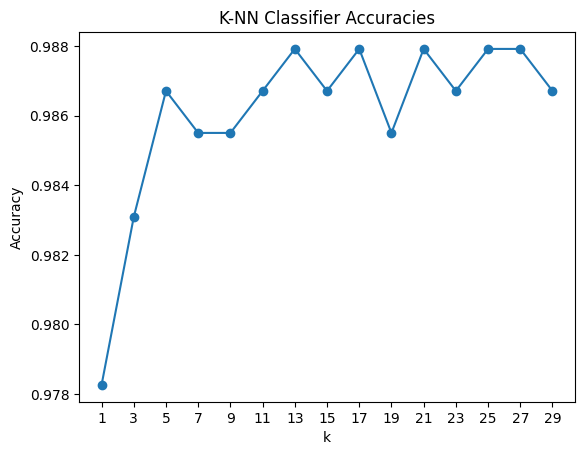

In [8]:
# Plot accuracy of k-NN
plt.title("K-NN Classifier Accuracies")
plt.plot(ks, knn_accs, '-o')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.xticks(ks)

# Export figure
plt.savefig("./knn_classifier_accuracies.png", bbox_inches='tight')
plt.show()

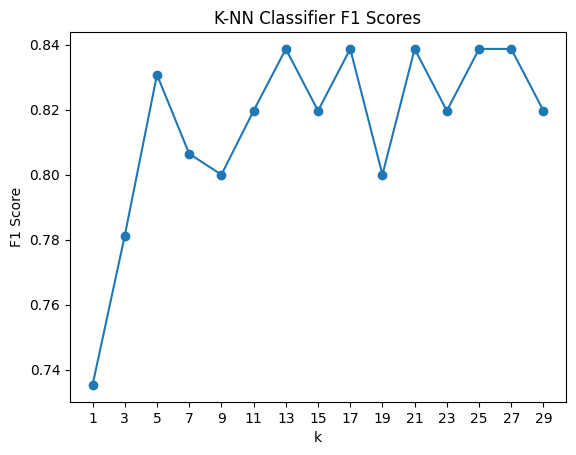

In [9]:
# Plot accuracy of k-NN
plt.title("K-NN Classifier F1 Scores")
plt.plot(ks, knn_f1s, '-o')
plt.xlabel("k")
plt.ylabel("F1 Score")
plt.xticks(ks)

# Export figure
plt.savefig("./knn_classifier_f1s.png", bbox_inches='tight')
plt.show()

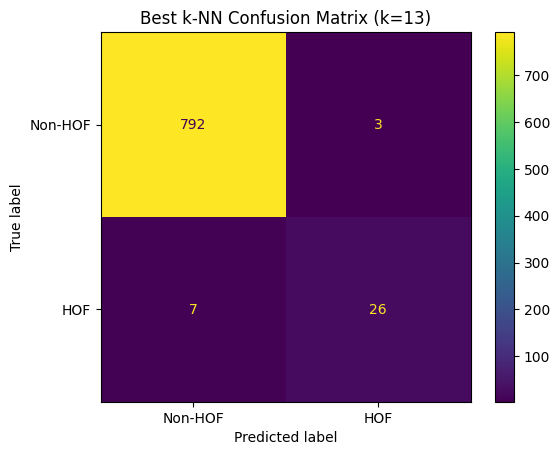

In [10]:
# Plot confusion matrix of best k-NN model
knn_preds = best_knn.predict(X_test_sc)
knn_cm = confusion_matrix(y_test, knn_preds)
knn_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=knn_cm,
    display_labels=['Non-HOF', 'HOF'])
knn_cm_disp.plot()
plt.title("Best k-NN Confusion Matrix (k=13)")
plt.savefig("./knn_classifier_conf_mat.png", bbox_inches='tight')
plt.show()

Logistic Regression Classifier:
-----------------------
LogisticRegression(max_iter=500, random_state=43, solver='liblinear')
acc=0.987923  f1=0.852941


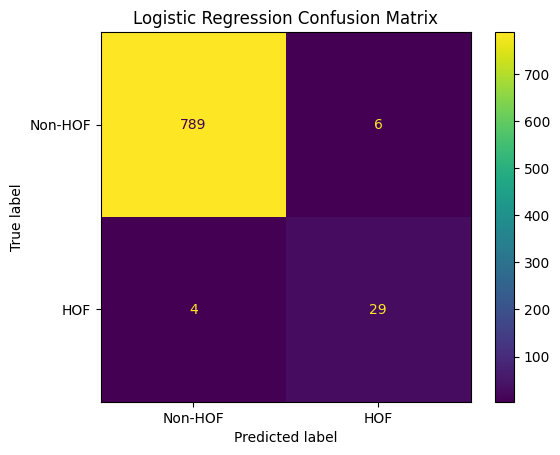

In [11]:
# Create and train Gaussian Naive Bayes Model
lr = LogisticRegression(max_iter=500, 
                        solver='liblinear',
                        random_state=43)
lr_preds = lr.fit(X_train, y_train).predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)
print(f"Logistic Regression Classifier:\n-----------------------\n{lr}")
print(f"acc={round(lr_acc, 6)}  f1={round(lr_f1, 6)}")

# Create and plot confusion matrix
lr_cm = confusion_matrix(y_test, lr_preds)
lr_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=lr_cm, 
    display_labels=['Non-HOF', 'HOF'])
lr_cm_disp.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.savefig("./lr_classifier_conf_mat.png", bbox_inches='tight')
plt.show()

In [22]:
# Create lists of different parameter values to test
class_weight = [None, 'balanced']
max_depth = list(range(1, 9, 2))
n_estimators = [1, 10, 25, 50, 100, 150, 200]

# Create empty array to hold acc/f1 data of Random Forest Classifiers
# index 0 holds class_weight=None, index 1 holds class_weight='balanced'
cw_acc_data = []
cw_f1_data = []

# Initalize variable to hold best Random Forest Classifier
best_rf = None
best_rf_f1 = 0
best_rf_acc = 0

# Trains and evaluates RandomForestClassifier on each combination of params
# Stores accuracy and f1 scores
for i in range(len(class_weight)):
    cw = class_weight[i]

    # Create empty array to hold plot data
    rf_accs = np.zeros((len(max_depth), len(n_estimators)))
    rf_f1s = np.zeros((len(max_depth), len(n_estimators)))

    # Iterate through each n_estimator and max_depth combination
    for n in range(len(n_estimators)):
        for d in range(len(max_depth)):

            # Train model and make predictions
            rf = RandomForestClassifier(
                    max_depth=max_depth[d], 
                    n_estimators=n_estimators[n],
                    class_weight=cw,
                    random_state=43)
            rf_preds = rf.fit(X_train, y_train).predict(X_test)

            # Store performance
            rf_acc = accuracy_score(y_test, rf_preds)
            rf_f1 = f1_score(y_test, rf_preds)
            rf_accs[d][n] = rf_acc
            rf_f1s[d][n] = rf_f1
            if rf_f1 > best_rf_f1:
                best_rf = rf
                best_rf_f1 = rf_f1
                best_rf_acc = rf_acc
    
    # Store data
    cw_acc_data.append(rf_accs)
    cw_f1_data.append(rf_f1s)


print(f"Best Random Forest Classifier\n------------------------------")
print(best_rf)
print(f"Accuracy: {best_rf_acc}, F1 Score: {best_rf_f1}")

Best Random Forest Classifier
------------------------------
RandomForestClassifier(max_depth=7, n_estimators=25, random_state=43)
Accuracy: 0.9903381642512077, F1 Score: 0.875


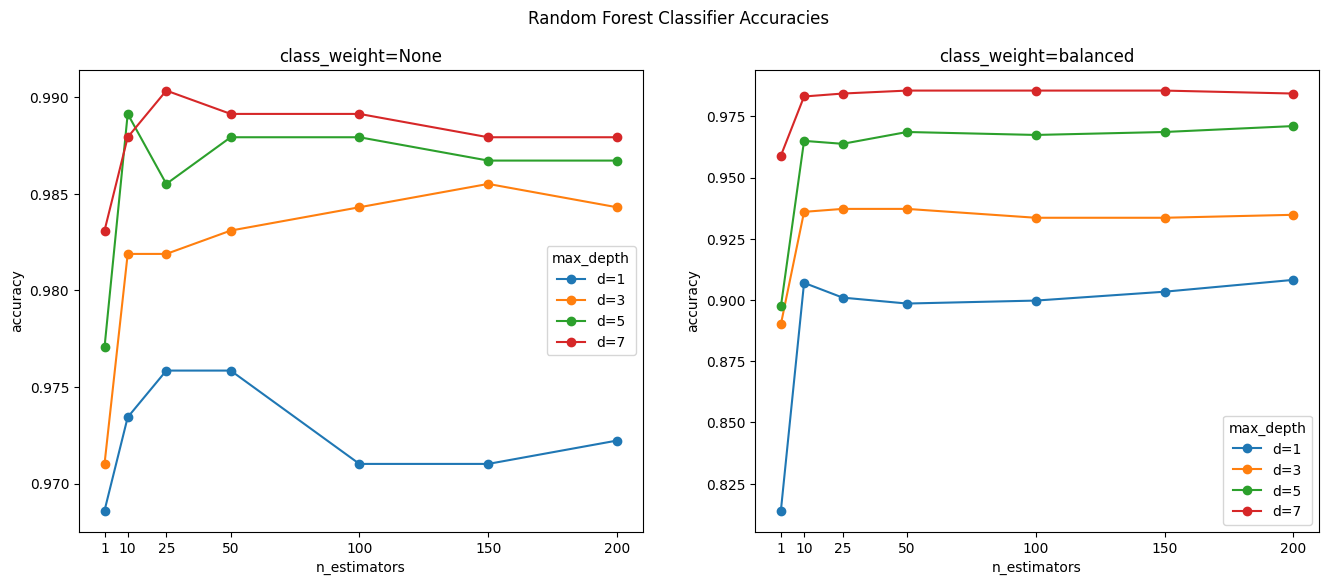

In [23]:
# Plot graphs for accuracy scores
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Random Forest Classifier Accuracies")

for i in range(len(class_weight)):
    acc_data = cw_acc_data[i]
    for d in range(len(max_depth)):
        ax[i].plot(n_estimators, acc_data[d], '-o', label=f"d={max_depth[d]}")
    ax[i].set_title(f"class_weight={class_weight[i]}")
    ax[i].set_xticks(n_estimators)
    ax[i].legend(title="max_depth")
    ax[i].set_xlabel('n_estimators')
    ax[i].set_ylabel('accuracy')

# Save figure
plt.savefig('./rf_classifier_accuracies.png', bbox_inches='tight')
plt.show()

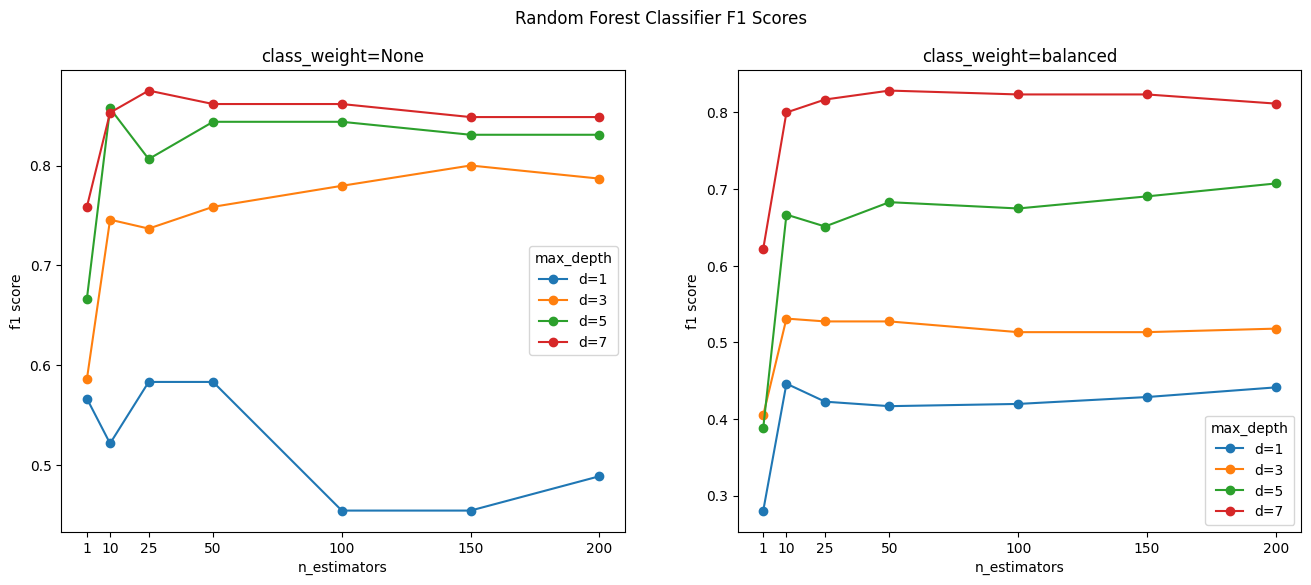

In [24]:
# Plot graphs for f1 scores
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Random Forest Classifier F1 Scores")

for i in range(len(class_weight)):
    f1_data = cw_f1_data[i]
    for d in range(len(max_depth)):
        ax[i].plot(n_estimators, f1_data[d], '-o', label=f"d={max_depth[d]}")
    ax[i].set_title(f"class_weight={class_weight[i]}")
    ax[i].set_xticks(n_estimators)
    ax[i].legend(title="max_depth")
    ax[i].set_xlabel('n_estimators')
    ax[i].set_ylabel('f1 score')

# Save figure
plt.savefig('./rf_classifier_f1s.png', bbox_inches='tight')
plt.show()

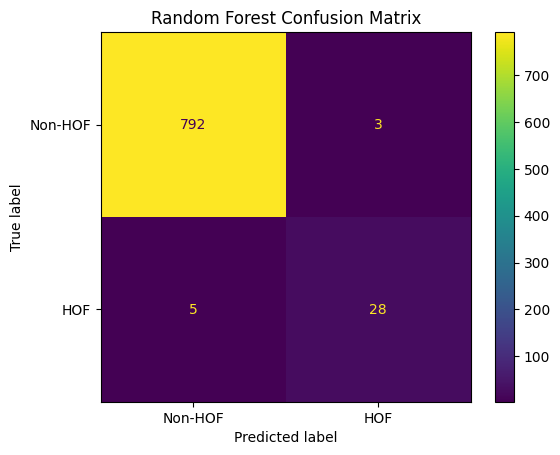

In [25]:
# Make predictions with best RandomForestClassifier
rf_preds = best_rf.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_preds)
rf_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=rf_cm, 
    display_labels=['Non-HOF', 'HOF'])
rf_cm_disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.savefig("./rf_classifier_conf_mat.png", bbox_inches='tight')
plt.show()

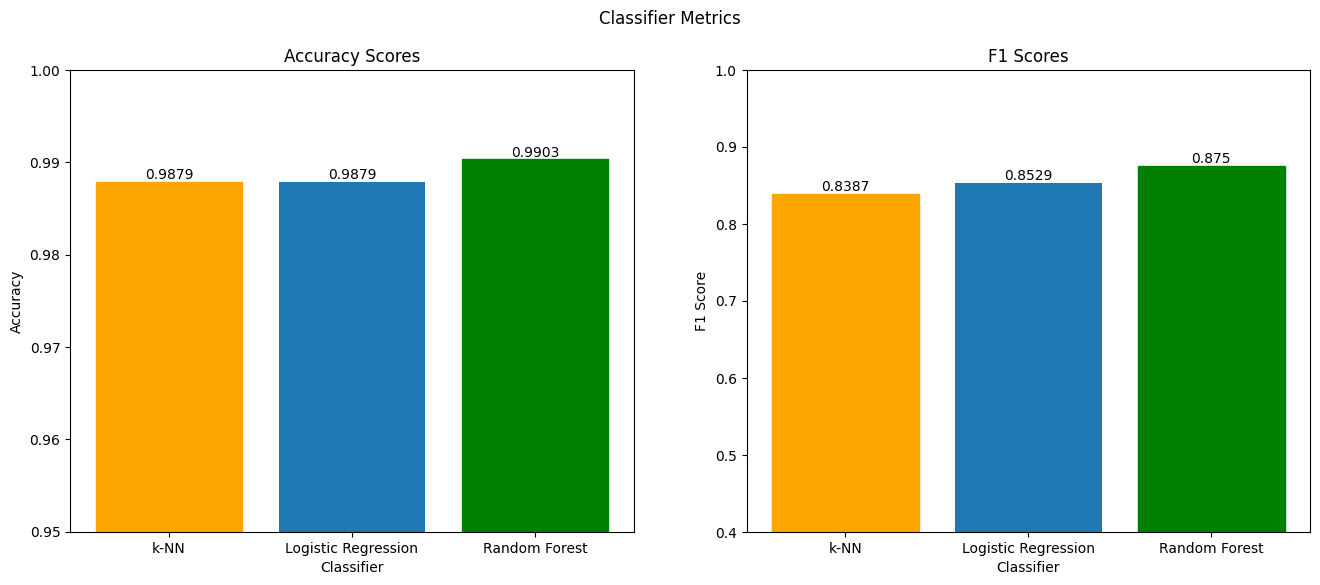

In [36]:
# Join accuracy and f1 scores of each model into arrays to plot
all_accs = [round(best_knn_acc, 4), 
            round(lr_acc, 4), 
            round(best_rf_acc, 4)]
all_f1s = [round(best_knn_f1, 4), 
            round(lr_f1, 4), 
            round(best_rf_f1, 4)]

# Create plot
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

# Plot accuracies
acc_bars = ax[0].bar(np.arange(3), all_accs)
ax[0].set_xticks(np.arange(3), ["k-NN", "Logistic Regression", "Random Forest"])
ax[0].set_ylim(0.95, 1.0)
ax[0].bar_label(acc_bars, labels=all_accs)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Classifier')
ax[0].set_title('Accuracy Scores')
acc_bars[0].set_color('orange')
acc_bars[2].set_color('green')

# Plot f1 scores
f1_bars = ax[1].bar(np.arange(3), all_f1s)
ax[1].set_xticks(np.arange(3), ["k-NN", "Logistic Regression", "Random Forest"])
ax[1].bar_label(f1_bars, labels=all_f1s)
ax[1].set_ylim(0.4, 1)
ax[1].set_ylabel('F1 Score')
ax[1].set_xlabel('Classifier')
ax[1].set_title('F1 Scores')
f1_bars[0].set_color('orange')
f1_bars[2].set_color('green')

fig.suptitle("Classifier Metrics")

# Save figure
plt.savefig('./classifier_metrics_bar.png', bbox_inches='tight')
plt.show()

In [27]:
# Make predictions on current players
curr_players = nba_df[nba_df['To'] > 2018].copy(deep=True)
curr_preds = best_rf.predict(curr_X)
curr_players['HOF'] = curr_preds

# Display players who are predicted to enter the Hall of Fame
print(f"Players Projected to Enter Hall of Fame")
display(curr_players[curr_players['HOF'] == 1])

Players Projected to Enter Hall of Fame


,Player,From,To,Years,Pos,Ht,Height,Wt,G,PTS,...,ROY,AS MVP,CF MVP,Finals MVP,MVP,Championships,NBA 75 Team,ABA All-Time Team,class,HOF
45,LaMarcus Aldridge,2007,2022,16,F-C,6-11,6.916667,250.0,1076,19.1,...,0,0,0,0,0,0,0,0,0,1
116,Giannis Antetokounmpo,2014,2022,9,G-F,6-11,6.916667,242.0,656,21.8,...,0,1,0,1,2,1,1,0,0,1
119,Carmelo Anthony,2004,2022,19,F,6-7,6.583333,238.0,1260,22.5,...,0,0,0,0,0,0,1,0,0,1
643,Jimmy Butler,2012,2022,11,G-F,6-7,6.583333,230.0,690,17.7,...,0,0,0,0,0,0,0,0,0,1
721,Vince Carter,1999,2020,22,G-F,6-6,6.500000,220.0,1541,16.7,...,1,0,0,0,0,0,0,0,0,1
961,Stephen Curry,2010,2022,13,G,6-2,6.166667,185.0,826,24.3,...,0,1,1,1,2,4,1,0,0,1
995,Anthony Davis,2013,2022,10,F-C,6-10,6.833333,253.0,604,23.8,...,0,1,0,0,0,1,1,0,0,1
1055,DeMar DeRozan,2010,2022,13,G-F,6-6,6.500000,220.0,957,20.8,...,0,0,0,0,0,0,0,0,0,1
1199,Kevin Durant,2008,2022,15,G-F,6-10,6.833333,240.0,939,27.2,...,1,2,0,2,1,2,1,0,0,1
1277,Joel Embiid,2017,2022,6,C,7-0,7.000000,280.0,328,26.0,...,0,0,0,0,0,0,0,0,0,1
